In [107]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
pd.set_option('max_columns', None)

In [108]:
df = pd.read_csv('./data/diabetic_data.csv', na_values='?')
df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Missing Values

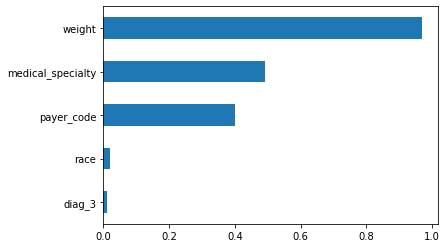

In [109]:
missing = round((df.isna().sum()/len(df)),2).sort_values(ascending = True)
missing = missing[missing > 0]
missing.plot(kind='barh')

In [110]:
# drop weight
drop_cols = ['encounter_id', 'patient_nbr', 'weight','admission_type_id',
 'discharge_disposition_id',
 'admission_source_id', 'diag_1','diag_2','diag_3']
df.drop(drop_cols, axis=1, inplace = True)


In [111]:
# payer code - mode
df.loc[df['payer_code'].isnull(), 'payer_code'] = df['payer_code'].value_counts().index[0]

In [112]:
# drop medical specialty column
print('Number of unique medical specialty',str(len(df['medical_specialty'].unique())))
df.drop('medical_specialty', axis=1, inplace=True)

Number of unique medical specialty 73


In [113]:
# remaining missing values
df.dropna(axis=0, inplace=True)
print('Number of missing values: ',str((df.isna().sum() > 0).sum()))

Number of missing values:  0


In [114]:
## gender
df = df[df['gender']!='Unknown/Invalid']

# Feature Engineering

In [115]:
df['age'] = df['age'].map({'[10-20)':20, '[20-30)':30, '[30-40)':40, '[40-50)':50, '[50-60)':60, '[60-70)':70,
                           '[70-80)':80, '[80-90)':90, '[90-100)':100, '[0-10)':10})

In [116]:
df['max_glu_serum'] = df['max_glu_serum'].map({'None':0, 'Norm':100, '>200':200, '>300':300})

In [117]:
df['A1Cresult']= df.A1Cresult.map({'None':0,'Norm':3,'>7':7,'>8':8})

In [118]:
medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for med in medication:
    df[med] = df[med].map({'Up':1, 'Down':-1, 'Steady':0, 'No':-2})

In [119]:
df['change'] = df['change'].map({'Ch':1,'No':0})

In [120]:
df['diabetesMed'] = df.diabetesMed.map({'Yes':1, 'No':0})

In [121]:
df['readmitted'] = df.readmitted.map({'NO':0, '>30':0, '<30':1})

# Preprocessing Numeric and Categorical Features

## Numeric Features

In [122]:
categorical = []
continuous = []

for col in df.columns:
    if df[col].dtype == 'O':
        categorical.append(col)
    elif col != 'readmitted':
        continuous.append(col)
        



In [123]:
print(categorical, end = '\n')
print(continuous)

['race', 'gender', 'payer_code']
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


## Encoding / Scaling

In [124]:
X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [125]:
X = pd.get_dummies(X, columns = categorical)

In [126]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

## Train Test Split / SMOTE

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, stratify = y, random_state = 42)

In [129]:
X_train

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC
94614,-0.059914,0.201391,1.011756,-0.786851,0.119887,-0.292416,-0.214200,0.280717,0.810344,-0.213874,-0.418572,1.969439,-0.123452,-0.083434,-0.028973,4.217648,-0.00317,-0.371901,-0.335452,-0.014872,-0.277044,-0.256999,-0.054893,-0.019092,-0.005491,-0.019743,0.0,0.0,0.858913,-0.082819,-0.011432,-0.00317,0.0,-0.00317,1.080328,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,0.925775,-0.925775,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,-1.590940,-0.189075,-0.02783,9.801294,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
51782,1.194505,0.536180,0.910210,0.974046,0.366200,1.274002,-0.214200,-0.505840,0.810344,-0.213874,-0.418572,-0.488071,-0.123452,-0.083434,-0.028973,-0.227950,-0.00317,-0.371901,2.842188,-0.014872,-0.277044,-0.256999,-0.054893,-0.019092,-0.005491,-0.019743,0.0,0.0,-0.959801,-0.082819,-0.011432,-0.00317,0.0,-0.00317,-0.925644,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,-1.080176,1.080176,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,0.628559,-0.189075,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
55080,-0.687124,-0.468187,0.097841,1.561012,0.735668,-0.292416,-0.214200,-0.505840,-0.747262,-0.213874,-0.418572,-0.488071,-0.123452,-0.083434,-0.028973,-0.227950,-0.00317,-0.371901,-0.335452,-0.014872,-0.277044,-0.256999,-0.054893,-0.019092,-0.005491,-0.019743,0.0,0.0,0.858913,-0.082819,-0.011432,-0.00317,0.0,-0.00317,-0.925644,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,0.925775,-0.925775,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,-1.590940,5.288915,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
80378,0.567295,-1.137765,-0.359116,-0.786851,-0.742207,-0.292416,0.849657,0.280717,-0.747262,-0.213874,-0.418572,-0.488071,-0.123452,-0.083434,-0.028973,-0.227950,-0.00317,-0.371901,-0.335452,-0.014872,-0.277044,-0.256999,-0.054893,-0.019092,-0.005491,-0.019743,0.0,0.0,-0.959801,-0.082819,-0.011432,-0.00317,0.0,-0.00317,-0.925644,-1.823609,2.044304,-0.080526,-1.803626,-0.144575,-0.123932,0.925775,-0.925775,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,0.628559,-0.189075,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
71486,-0.059914,0.201391,1.417940,-0.199885,0.858824,2.840419,1.913513,-0.505840,0.810344,-0.213874,-0.418572,1.969439,-0.123452,-0.083434,-0.028973,-0.227950,-0.00317,-0.371901,-0.335452,-0.014872,-0.277044,-0.256999,17.822171,-0.019092,-0.005491,-0.019743,0.0,0.0,1.768271,-0.082819,-0.011432,-0.00317,0.0,-0.00317,1.080328,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,-1.080176,1.080176,-0.218689,-0.038072,7.130621,-0.159324,-0.073459,-0.256194,-1.590940,-0.189075,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54780,1.194505,1.540546,1.468714,-0.786851,-0.495894,-0.292416,-0.214200,0.280717,0.810344,-0.213874,-0.418572,-0.488071

Text(0.5, 1.0, 'Imbalanced Dataset')

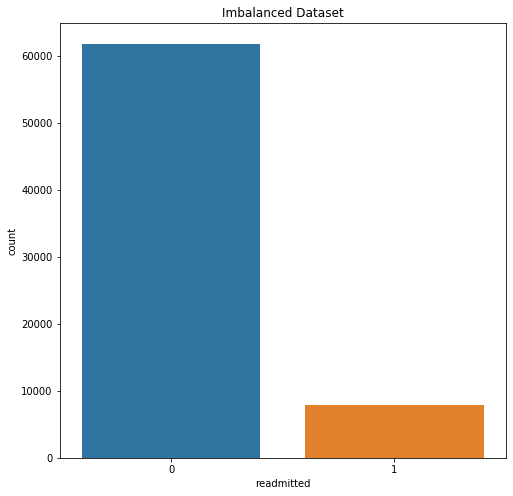

In [158]:
plt.figure(figsize=(8,8))
sns.countplot(y_train)
plt.title('Imbalanced Dataset')

In [131]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# Helper Functions

In [235]:
# Plot ROC Curve
def plot_roc_curve(model, title = "ROC Curve", X_test = X_test, y_test = y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (10,8))
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f"%roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()
    
# Print Confusion Matrix / Classification Report
def show_metrics(model, X_test = X_test, y_test = y_test):
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    print('-'*40)
    print(confusion_matrix(y_test, preds))

# Training Machine Learning Models

In [135]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score


## Random Forest Classifier

In [137]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs = -1)

rf_clf.fit(X_train_res, y_train_res)
rf_preds = rf_clf.predict(X_test)

In [236]:
show_metrics(rf_clf)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     26497
           1       0.28      0.03      0.05      3351

    accuracy                           0.88     29848
   macro avg       0.58      0.51      0.49     29848
weighted avg       0.82      0.88      0.84     29848

----------------------------------------
[[26266   231]
 [ 3262    89]]


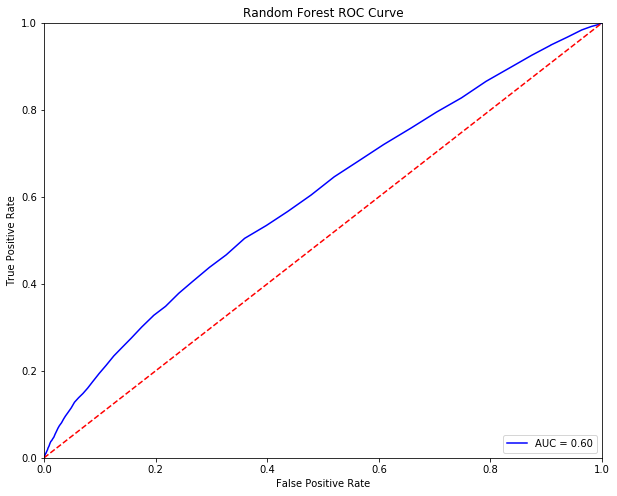

In [218]:
plot_roc_curve(rf_clf, title = "Random Forest ROC Curve")

In [302]:
pd.DataFrame(list(zip(X_train_res.columns, rf_clf.feature_importances_)), columns=['Feature','Importance']).sort_values('Importance').tail()

,Feature,Importance
4,num_medications,0.084801
0,age,0.104116
3,num_procedures,0.104904
1,time_in_hospital,0.113073
7,number_inpatient,0.144736


## Tuning Random Forest Hyperparameters

In [161]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [186]:
n_estimators = list(np.arange(200, 1000, 100))
max_depth = [2,3,4]
max_features = ['log2','auto','sqrt']

rf_params = {'n_estimators':n_estimators, 
             'max_depth':max_depth,
             'max_features':max_features}

grid_rf = GridSearchCV(estimator=rf_clf, 
                       param_grid=rf_params, 
                       scoring='roc_auc',
                       cv=3, 
                       verbose=1, 
                       n_jobs=-1)

In [187]:
grid_rf.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 18.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

In [237]:
show_metrics(grid_rf)

              precision    recall  f1-score   support

           0       0.91      0.74      0.82     26497
           1       0.17      0.42      0.24      3351

    accuracy                           0.70     29848
   macro avg       0.54      0.58      0.53     29848
weighted avg       0.83      0.70      0.75     29848

----------------------------------------
[[19606  6891]
 [ 1939  1412]]


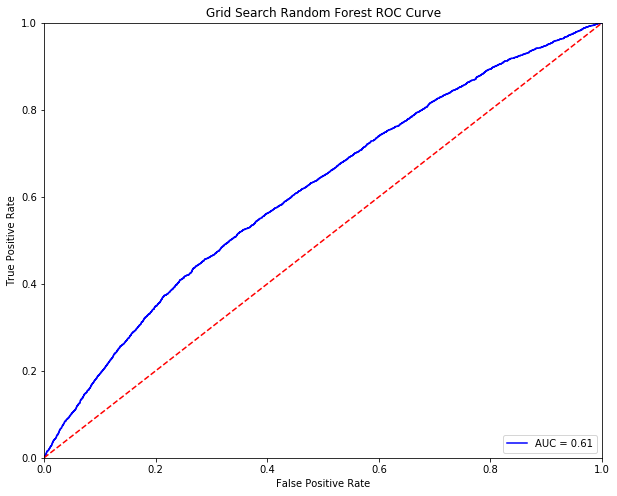

In [219]:
plot_roc_curve(best_rf, title = "Grid Search Random Forest ROC Curve")

In [281]:
rf_feature_importance = pd.DataFrame(list(zip(X_train_res.columns, best_rf.feature_importances_)), columns=['Feature', 'Importance']).sort_values('Importance', ascending = False)


In [282]:
rf_feature_importance

,Feature,Importance
7,number_inpatient,0.297222
1,time_in_hospital,0.148454
3,num_procedures,0.101661
8,number_diagnoses,0.085192
6,number_emergency,0.067937
0,age,0.057801
5,number_outpatient,0.057301
4,num_medications,0.056664
28,insulin,0.037767
10,A1Cresult,0.020226


## Logistic Regression

In [140]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train_res, y_train_res)
preds = logmodel.predict(X_test)

In [238]:
show_metrics(logmodel)

              precision    recall  f1-score   support

           0       0.92      0.65      0.76     26497
           1       0.16      0.53      0.25      3351

    accuracy                           0.63     29848
   macro avg       0.54      0.59      0.50     29848
weighted avg       0.83      0.63      0.70     29848

----------------------------------------
[[17113  9384]
 [ 1559  1792]]


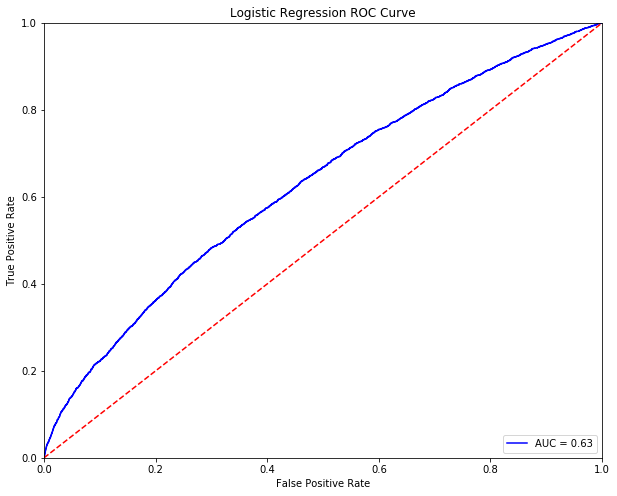

In [239]:
plot_roc_curve(logmodel, 'Logistic Regression ROC Curve')

## Logistic Regression + Bootstrap Aggregation

In [146]:
from sklearn.ensemble import BaggingClassifier

lr_bagger = BaggingClassifier(logmodel, n_jobs = -1, random_state = 42)
lr_bagger.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
                  random_state=42, ver

In [240]:
show_metrics(lr_bagger)

              precision    recall  f1-score   support

           0       0.92      0.65      0.76     26497
           1       0.16      0.53      0.25      3351

    accuracy                           0.63     29848
   macro avg       0.54      0.59      0.50     29848
weighted avg       0.83      0.63      0.70     29848

----------------------------------------
[[17157  9340]
 [ 1563  1788]]


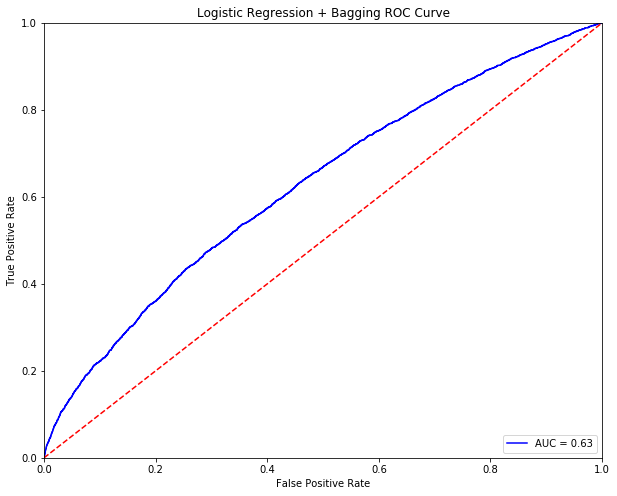

In [241]:
plot_roc_curve(lr_bagger, "Logistic Regression + Bagging ROC Curve")

## XGBoost Classifier

In [225]:
import xgboost as xgb 

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed = 42)
xgb_clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_2 = xgb.XGB

In [242]:
show_metrics(xgb_clf)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89     26497
           1       0.21      0.28      0.24      3351

    accuracy                           0.80     29848
   macro avg       0.56      0.57      0.56     29848
weighted avg       0.83      0.80      0.81     29848

----------------------------------------
[[23051  3446]
 [ 2424   927]]


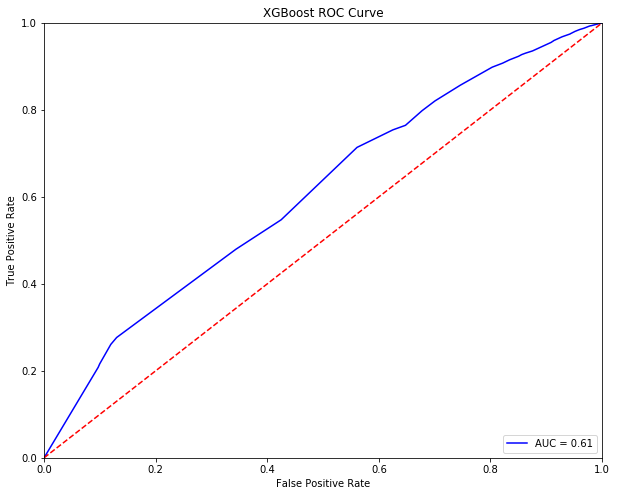

In [243]:
plot_roc_curve(xgb_clf, title="XGBoost ROC Curve")

## XGB Classifier Cross Validation 

In [247]:
# Create DMatrix
xgb_dmatrix = xgb.DMatrix(data = X_train_res, label = y_train_res)

# Parameter Dictionary
params = {"objective":"binary:logistic", 
          "max_depth":3}

# Cross Validation
xgb_cv = xgb.cv(dtrain=xgb_dmatrix, params=params, nfold=3,
                num_boost_round=5, metrics='auc', as_pandas=True,
                seed = 42)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [253]:
xgb_cv['test-auc-mean'].mean()

0.8193761333333333

## Grid Search With XGB

In [266]:
param_grid = {'n_estimators':np.arange(5,100,5),
              'max_depth':[2,4,6,8]}


grid_xgb = GridSearchCV(xgb_clf, param_grid=param_grid, scoring='roc_auc', 
                        cv=4, verbose=1, n_jobs=-1)

grid_xgb.fit(X_train_res, y_train_res)

Fitting 4 folds for each of 76 candidates, totalling 304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed: 39.2min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]

In [268]:
best_xgb = grid_xgb.best_estimator_
show_metrics(best_xgb)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     26497
           1       0.44      0.02      0.04      3351

    accuracy                           0.89     29848
   macro avg       0.67      0.51      0.49     29848
weighted avg       0.84      0.89      0.84     29848

----------------------------------------
[[26414    83]
 [ 3285    66]]


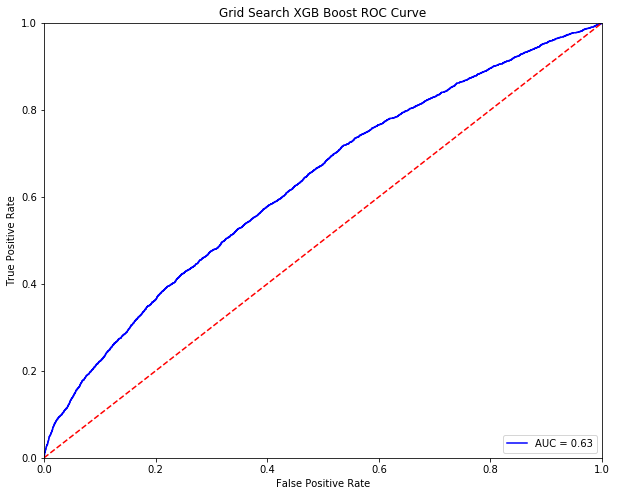

In [269]:
plot_roc_curve(best_xgb, "Grid Search XGB Boost ROC Curve")

# Ensembling

In [278]:
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(estimators = [('Random Forest',rf_clf),('Bagged Logistic Regression',lr_bagger),
                                       ('XGBoost',xgb_clf)], voting='soft')

voter.fit(X_train_res, y_train_res)


VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.

In [279]:
show_metrics(voter)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     26497
           1       0.24      0.19      0.22      3351

    accuracy                           0.84     29848
   macro avg       0.57      0.56      0.56     29848
weighted avg       0.83      0.84      0.83     29848

----------------------------------------
[[24430  2067]
 [ 2698   653]]


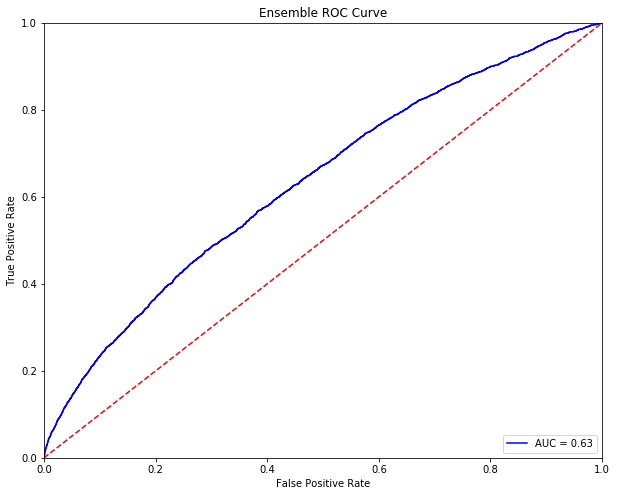

In [280]:
plot_roc_curve(voter, title="Ensemble ROC Curve")

In [275]:
# To Do 

# Feature Selection / Feature Scaling 
# Modeling (Random Forest, Logistic Regression, KNN Classifer, XGB) 
# GridSearch(Random Forest / Logistic Regression / )
# Plot ROC AUC Curve
# Feature importances in 


## Further Work ## 
# pipeline
